# DL training: Feature comparison on CNN model

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df_t5=pd.read_parquet('train/pspa_t5.parquet').reset_index()
df_esm=pd.read_parquet('train/pspa_esm.parquet').reset_index()
df_onehot = pd.read_parquet('train/pspa_onehot.parquet').reset_index()
df_onehot_pca = pd.read_parquet('train/pspa_onehot_pca.parquet').reset_index()

In [5]:
(df_onehot['index'] == df_esm['index']).value_counts()

index
True    368
Name: count, dtype: int64

In [6]:
(df_t5['index'] == df_esm['index']).value_counts()

index
True    368
Name: count, dtype: int64

In [7]:
t5_col = df_t5.columns[df_t5.columns.str.startswith('T5_')]

In [8]:
t5_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [9]:
esm_col = df_esm.columns[df_esm.columns.str.startswith('esm_')]

In [10]:
esm_col

Index(['esm_0', 'esm_1', 'esm_2', 'esm_3', 'esm_4', 'esm_5', 'esm_6', 'esm_7',
       'esm_8', 'esm_9',
       ...
       'esm_1270', 'esm_1271', 'esm_1272', 'esm_1273', 'esm_1274', 'esm_1275',
       'esm_1276', 'esm_1277', 'esm_1278', 'esm_1279'],
      dtype='object', length=1280)

In [11]:
target_col = df_t5.columns[~df_t5.columns.isin(t5_col)][1:]

In [12]:
target_col

Index(['-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P', '4P',
       ...
       '-5pY', '-4pY', '-3pY', '-2pY', '-1pY', '0pY', '1pY', '2pY', '3pY',
       '4pY'],
      dtype='object', length=230)

In [13]:
onehot_col = df_onehot.columns[~df_onehot.columns.isin(target_col)][1:]

In [14]:
onehot_col

Index(['65_-', '65_A', '65_C', '65_D', '65_E', '65_F', '65_G', '65_H', '65_I',
       '65_K',
       ...
       '3192_M', '3192_N', '3192_P', '3192_Q', '3192_R', '3192_S', '3192_T',
       '3192_V', '3192_W', '3192_Y'],
      dtype='object', length=6849)

In [15]:
onehot_pca_col = df_onehot_pca.columns[df_onehot_pca.columns.str.startswith('PCA')]

In [16]:
onehot_pca_col

Index(['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9',
       'PCA10',
       ...
       'PCA991', 'PCA992', 'PCA993', 'PCA994', 'PCA995', 'PCA996', 'PCA997',
       'PCA998', 'PCA999', 'PCA1000'],
      dtype='object', length=1000)

In [17]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

pspa_info = pd.DataFrame(df_t5['index'].tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)
pspa_info['family'] = pspa_info.kinase.map(family_map)
pspa_info['group'] = pspa_info.kinase.map(group_map)

## Split

In [18]:
splits = get_splits(pspa_info, group='group',nfold=9)

split0 = splits[0]

GroupKFold(n_splits=9, random_state=None, shuffle=False)
# group in train set: 8
# group in test set: 1


## Dataset

In [19]:
# dataset
ds_t5 = GeneralDataset(df_t5,t5_col,target_col)
ds_esm = GeneralDataset(df_esm,esm_col,target_col)
ds_onehot = GeneralDataset(df_onehot,onehot_col,target_col)
ds_onehot_pca = GeneralDataset(df_onehot_pca,onehot_pca_col,target_col)


In [20]:
len(ds_t5)

368

In [21]:
dl_t5 = DataLoader(ds_t5, batch_size=64, shuffle=True)
dl_esm = DataLoader(ds_esm, batch_size=64, shuffle=True)
dl_onehot = DataLoader(ds_onehot, batch_size=64, shuffle=True)
dl_onehot_pca = DataLoader(ds_onehot_pca, batch_size=64, shuffle=True)


In [22]:
xb,yb = next(iter(dl_t5))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Model

In [23]:
n_t5 = len(t5_col)
n_esm = len(esm_col)
n_onehot = len(onehot_col)
n_onehot_pca = len(onehot_pca_col)
n_target = len(target_col)

In [24]:
n_t5,n_esm,n_onehot,n_onehot_pca

(1024, 1280, 6849, 1000)

In [25]:

# def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

def get_cnn_t5(): return PSSM_model(n_t5,n_target,model='CNN')
def get_cnn_esm(): return PSSM_model(n_esm,n_target,model='CNN')
def get_cnn_onehot(): return PSSM_model(n_onehot,n_target,model='CNN')
def get_cnn_onehot_pca(): return PSSM_model(n_onehot_pca,n_target,model='CNN')


In [26]:
model = get_cnn_t5()

In [27]:
logits= model(xb)

In [28]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [29]:
CE(logits,yb)

tensor(3.3157, grad_fn=<MeanBackward0>)

## Metrics

In [30]:
KLD(logits,yb)

tensor(0.5744, grad_fn=<MeanBackward0>)

In [31]:
JSD(logits,yb)

tensor(0.1175, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [32]:
oof_t5 = train_dl_cv(df_t5,t5_col,target_col,
                  splits = splits,
                  model_func = get_cnn_t5,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.265647,3.142609,0.404048,0.081247,00:01
1,3.223042,3.159432,0.420871,0.084551,00:00
2,3.185979,3.188326,0.449765,0.093861,00:00
3,3.161986,3.216524,0.477963,0.093619,00:00
4,3.139796,3.263382,0.524821,0.094843,00:00
5,3.121998,3.365554,0.626993,0.100610,00:00
6,3.081605,3.490378,0.751817,0.110248,00:00
7,3.036093,3.435781,0.697220,0.096045,00:00
8,2.995330,3.547961,0.809401,0.095060,00:00
9,2.961592,3.593616,0.855055,0.096466,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.202563,3.126681,0.367288,0.080953,00:00
1,3.096495,2.987177,0.227784,0.058128,00:00
2,3.020704,2.896720,0.137328,0.032520,00:00
3,2.977764,2.916249,0.156856,0.036941,00:00
4,2.950588,2.900061,0.140669,0.032257,00:00
5,2.930088,2.912244,0.152851,0.035243,00:00
6,2.911221,2.882244,0.122852,0.028578,00:00
7,2.896883,2.888497,0.129105,0.029880,00:00
8,2.883235,2.879527,0.120135,0.028295,00:00
9,2.869442,2.870536,0.111143,0.025767,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.193643,3.129775,0.413172,0.088697,00:00
1,3.091510,2.970952,0.254349,0.061493,00:00
2,3.019390,2.939329,0.222726,0.047996,00:00
3,2.979136,2.997280,0.280677,0.057836,00:00
4,2.955849,2.856279,0.139675,0.032778,00:00
5,2.937262,2.881608,0.165005,0.037116,00:00
6,2.919667,2.847731,0.131128,0.030217,00:00
7,2.905293,2.839630,0.123026,0.028822,00:00
8,2.891868,2.834224,0.117620,0.027419,-1:59:59
9,2.879336,2.883239,0.166636,0.039591,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.207944,3.141091,0.449947,0.093460,00:00
1,3.110341,3.029324,0.338180,0.076213,00:00
2,3.034141,2.932320,0.241176,0.049031,00:00
3,2.993638,2.946054,0.254910,0.050688,00:00
4,2.968643,2.946317,0.255174,0.049163,00:00
5,2.946927,2.940749,0.249605,0.046374,00:00
6,2.926885,2.924870,0.233727,0.044772,00:00
7,2.909749,2.939194,0.248050,0.045244,00:00
8,2.893957,2.910057,0.218914,0.042975,00:00
9,2.879583,2.939824,0.248680,0.046253,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.193083,3.121557,0.332112,0.073863,00:00
1,3.084162,2.954197,0.164753,0.042711,00:00
2,3.010259,2.942940,0.153495,0.035771,00:00
3,2.970550,2.977695,0.188250,0.042826,00:00
4,2.945946,2.932550,0.143106,0.032621,00:00
5,2.929771,2.907203,0.117758,0.027932,00:00
6,2.910526,2.899911,0.110467,0.025754,00:00
7,2.892773,2.916562,0.127117,0.028903,00:00
8,2.879743,2.905592,0.116148,0.026998,00:00
9,2.866278,2.908514,0.119069,0.027786,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.191223,3.125971,0.337161,0.074101,00:00
1,3.084095,2.968137,0.179327,0.046755,00:00
2,3.009351,2.993795,0.204984,0.046834,00:00
3,2.975441,2.935275,0.146464,0.035559,00:00
4,2.952728,2.906648,0.117838,0.029097,00:00
5,2.933139,2.887461,0.098650,0.024654,00:00
6,2.914009,2.891163,0.102352,0.025090,00:00
7,2.896947,2.894362,0.105552,0.025792,00:00
8,2.880326,2.898649,0.109838,0.026552,00:00
9,2.865264,2.895405,0.106595,0.026206,-1:59:59


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.203619,3.121918,0.306652,0.069884,00:00
1,3.089997,2.956834,0.141568,0.037513,00:00
2,3.015747,2.923789,0.108523,0.025009,00:00
3,2.973150,2.941699,0.126433,0.029847,00:00
4,2.948111,2.920527,0.105260,0.024720,00:00
5,2.928955,2.909259,0.093993,0.021972,00:00
6,2.909893,2.905155,0.089889,0.021540,00:00
7,2.892313,2.922608,0.107342,0.024919,00:00
8,2.876400,2.927285,0.112019,0.026551,00:00
9,2.861295,2.911070,0.095804,0.022932,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.199715,3.125819,0.463774,0.099700,00:00
1,3.084667,2.961773,0.299728,0.067936,00:00
2,3.013755,2.959561,0.297516,0.064850,00:00
3,2.980244,3.010867,0.348822,0.071755,00:00
4,2.960497,3.011438,0.349393,0.073356,00:00
5,2.937192,3.053991,0.391946,0.081665,00:00
6,2.913795,2.971227,0.309182,0.067685,00:00
7,2.894401,2.922726,0.260681,0.059278,00:00
8,2.877291,2.889860,0.227814,0.052599,00:00
9,2.863354,2.906056,0.244011,0.056762,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.204548,3.130516,0.332384,0.072145,00:00
1,3.086863,2.963805,0.165674,0.039414,00:00
2,3.013082,2.931495,0.133363,0.028549,00:00
3,2.972725,2.921883,0.123751,0.026929,00:00
4,2.949337,2.924575,0.126443,0.027342,00:00
5,2.929606,2.938754,0.140622,0.029565,00:00
6,2.907469,2.928634,0.130502,0.028092,00:00
7,2.891385,2.991267,0.193135,0.042524,00:00
8,2.875030,2.937675,0.139543,0.031085,00:00
9,2.861556,3.244176,0.446044,0.061041,-1:59:59


In [33]:
oof_esm = train_dl_cv(df_esm,esm_col,target_col,
                  splits = splits,
                  model_func = get_cnn_esm,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.264869,3.136897,0.398337,0.080906,00:00
1,3.217183,3.158689,0.420129,0.083298,00:00
2,3.185448,3.175242,0.436681,0.091017,00:00
3,3.167979,3.221153,0.482592,0.094919,00:00
4,3.154100,3.221832,0.483271,0.091278,00:00
5,3.117338,3.316915,0.578354,0.099876,00:00
6,3.072603,3.407976,0.669415,0.101000,00:00
7,3.027419,3.488302,0.749741,0.101484,00:00
8,2.988770,3.563498,0.824937,0.102865,00:00
9,2.956225,3.565761,0.827200,0.100375,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.193581,3.120010,0.360617,0.080228,00:00
1,3.084519,2.978762,0.219370,0.055952,00:00
2,3.013452,2.900385,0.140992,0.033519,00:00
3,2.977241,2.921838,0.162445,0.038445,00:00
4,2.955385,2.901993,0.142601,0.033416,00:00
5,2.934080,2.874330,0.114937,0.027168,00:00
6,2.914432,2.875653,0.116260,0.027577,00:00
7,2.898649,2.873714,0.114322,0.026822,00:00
8,2.884012,2.866899,0.107507,0.025204,00:00
9,2.872340,2.869269,0.109877,0.025642,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.202004,3.115519,0.398916,0.087196,00:00
1,3.087065,2.949936,0.233333,0.057611,00:00
2,3.018293,2.917029,0.200425,0.044855,00:00
3,2.982141,2.866996,0.150393,0.034669,00:00
4,2.967630,2.867355,0.150751,0.034402,00:00
5,2.947072,2.836027,0.119424,0.027516,00:00
6,2.927675,2.837569,0.120966,0.027518,00:00
7,2.910500,2.843097,0.126494,0.028759,00:00
8,2.894355,2.836293,0.119690,0.027306,00:00
9,2.880376,2.854691,0.138088,0.030649,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.202962,3.118910,0.427766,0.090941,00:00
1,3.089748,2.952767,0.261623,0.059470,00:00
2,3.022268,2.934290,0.243146,0.048406,00:00
3,2.988155,2.941152,0.250008,0.050903,00:00
4,2.967207,2.961673,0.270530,0.051580,00:00
5,2.951866,2.943200,0.252056,0.047716,00:00
6,2.932044,2.940075,0.248931,0.046150,00:00
7,2.913869,2.947825,0.256681,0.047069,00:00
8,2.898216,2.935129,0.243985,0.044736,00:00
9,2.884012,2.921401,0.230257,0.044297,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.206472,3.133298,0.343854,0.075123,00:00
1,3.087475,2.981167,0.191722,0.049670,00:00
2,3.015009,2.916325,0.126880,0.029111,00:00
3,2.975545,2.920883,0.131439,0.031650,00:00
4,2.957316,2.924036,0.134591,0.031509,00:00
5,2.939080,2.909500,0.120055,0.028545,00:00
6,2.919973,2.902207,0.112762,0.026220,00:00
7,2.901022,2.903212,0.113767,0.026729,00:00
8,2.884898,2.912332,0.122887,0.028784,00:00
9,2.869776,2.908447,0.119002,0.027865,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.187245,3.128074,0.339263,0.073991,00:00
1,3.071628,2.986283,0.197472,0.051019,00:00
2,3.001887,2.903810,0.114999,0.027137,00:00
3,2.964702,2.911484,0.122673,0.029126,00:00
4,2.946854,2.900443,0.111632,0.027561,00:00
5,2.930545,2.896069,0.107258,0.026062,00:00
6,2.911004,2.905382,0.116571,0.028297,00:00
7,2.894996,2.917508,0.128697,0.030506,00:00
8,2.880330,2.887178,0.098368,0.024039,00:00
9,2.869907,2.887413,0.098603,0.023499,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.188190,3.114348,0.299082,0.069039,00:00
1,3.063660,2.943110,0.127844,0.033852,00:00
2,2.997336,2.917790,0.102524,0.024700,00:00
3,2.964889,2.925680,0.110414,0.026368,00:00
4,2.947123,3.018301,0.203035,0.039962,00:00
5,2.928940,2.961387,0.146121,0.031864,00:00
6,2.911475,2.932888,0.117622,0.027504,00:00
7,2.892783,2.941010,0.125743,0.028919,00:00
8,2.877175,2.932807,0.117541,0.027764,00:00
9,2.863183,2.920175,0.104909,0.024967,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.187940,3.132055,0.470010,0.100920,00:00
1,3.072927,2.944816,0.282771,0.063020,00:00
2,3.001055,2.929518,0.267473,0.059566,00:00
3,2.969772,2.948422,0.286377,0.063104,00:00
4,2.948040,2.926207,0.264161,0.057537,00:00
5,2.931400,2.963588,0.301542,0.064320,00:00
6,2.909764,2.960949,0.298904,0.064112,00:00
7,2.895195,3.003662,0.341618,0.070389,00:00
8,2.879205,3.000879,0.338834,0.070586,00:00
9,2.865099,3.004148,0.342102,0.070332,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.191767,3.127610,0.329479,0.072123,00:00
1,3.075926,2.944713,0.146582,0.036049,00:00
2,3.003580,2.945038,0.146907,0.032734,00:00
3,2.966146,2.948486,0.150355,0.031666,00:00
4,2.945253,2.926992,0.128860,0.028842,00:00
5,2.926334,2.911107,0.112976,0.024992,00:00
6,2.906564,2.908641,0.110509,0.024338,00:00
7,2.889611,2.914251,0.116119,0.025042,00:00
8,2.875487,2.905566,0.107434,0.023223,00:00
9,2.862854,2.904928,0.106797,0.023156,00:00


In [34]:
oof_onehot = train_dl_cv(df_onehot,onehot_col,target_col,
                  splits = splits,
                  model_func = get_cnn_onehot,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.277120,3.133921,0.395361,0.080811,00:00
1,3.220052,3.143938,0.405378,0.082488,00:00
2,3.172967,3.197285,0.458724,0.086042,00:00
3,3.142990,3.197540,0.458979,0.088806,00:00
4,3.120064,3.194893,0.456332,0.089937,00:00
5,3.082074,3.265694,0.527133,0.094442,00:00
6,3.037489,3.350454,0.611893,0.096622,00:00
7,2.994622,3.459473,0.720912,0.097649,00:00
8,2.958157,3.513486,0.774925,0.095750,00:00
9,2.927430,3.566482,0.827921,0.097972,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.210148,3.139912,0.380520,0.082572,00:00
1,3.076796,3.013317,0.253924,0.063400,00:00
2,3.000978,2.891074,0.131682,0.031530,00:00
3,2.960962,2.920046,0.160653,0.037774,00:00
4,2.935330,2.882944,0.123551,0.028969,00:00
5,2.912577,2.878306,0.118913,0.027573,00:00
6,2.891449,2.862408,0.103015,0.024382,00:00
7,2.874047,2.857084,0.097691,0.023248,00:00
8,2.859166,2.862403,0.103011,0.024601,00:00
9,2.845874,2.874232,0.114840,0.027831,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.203027,3.133307,0.416704,0.088837,00:00
1,3.081909,2.938727,0.222124,0.055139,00:00
2,3.011248,2.851364,0.134761,0.030517,00:00
3,2.967336,2.879799,0.163196,0.037787,00:00
4,2.942564,2.865221,0.148617,0.033606,-1:59:59
5,2.921736,2.856464,0.139861,0.031637,00:00
6,2.902239,2.856883,0.140280,0.031034,00:00
7,2.883385,2.848513,0.131910,0.029322,00:00
8,2.867899,2.851038,0.134435,0.030472,00:00
9,2.854214,2.868535,0.151931,0.034805,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.217360,3.135256,0.444112,0.093500,00:00
1,3.089197,3.000559,0.309415,0.071229,00:00
2,3.013406,2.909544,0.218400,0.043400,00:00
3,2.973763,3.000403,0.309258,0.058953,00:00
4,2.950085,2.952441,0.261297,0.050864,00:00
5,2.926956,2.932818,0.241674,0.046230,00:00
6,2.905373,2.913712,0.222568,0.043278,00:00
7,2.886523,2.899899,0.208755,0.041040,00:00
8,2.871984,2.899730,0.208587,0.040406,00:00
9,2.859025,2.895478,0.204334,0.040991,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.221777,3.120676,0.331231,0.073846,00:01
1,3.079224,2.961355,0.171910,0.044981,00:00
2,3.000947,2.920985,0.131540,0.031555,00:00
3,2.962647,2.964863,0.175418,0.040005,00:00
4,2.940489,2.948510,0.159065,0.037153,00:00
5,2.917177,2.914334,0.124890,0.029468,00:00
6,2.894965,2.901642,0.112197,0.026065,00:00
7,2.875778,2.897019,0.107574,0.025436,00:00
8,2.859513,2.893893,0.104448,0.024652,00:00
9,2.845501,2.900487,0.111043,0.026683,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.199647,3.140137,0.351326,0.075517,00:00
1,3.064764,2.972414,0.183604,0.047527,00:00
2,2.991076,2.917917,0.129106,0.031017,00:00
3,2.949582,2.947464,0.158653,0.038191,00:00
4,2.925140,2.909489,0.120679,0.028941,00:00
5,2.902952,2.904005,0.115195,0.027851,00:00
6,2.882324,2.890948,0.102137,0.024815,00:00
7,2.863699,2.894485,0.105674,0.025504,00:00
8,2.848049,2.904008,0.115198,0.028467,00:00
9,2.834757,2.911851,0.123041,0.030428,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.211345,3.139642,0.324376,0.071962,00:00
1,3.079162,2.969423,0.154157,0.040900,00:00
2,3.002954,2.927417,0.112150,0.026776,00:00
3,2.957990,2.980102,0.164836,0.037336,00:00
4,2.934710,2.942456,0.127189,0.029204,00:00
5,2.913644,2.923435,0.108169,0.025080,00:00
6,2.891332,2.929808,0.114542,0.025729,00:00
7,2.871521,2.914588,0.099322,0.023127,00:00
8,2.854944,2.909274,0.094008,0.022614,00:00
9,2.840556,2.923026,0.107760,0.026119,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.207157,3.116577,0.454532,0.098201,00:21
1,3.068383,2.942939,0.280893,0.065497,00:00
2,2.993331,2.967219,0.305173,0.066856,00:02
3,2.952425,2.931577,0.269531,0.058940,07:28
4,2.924765,2.894598,0.232553,0.052688,00:00
5,2.902512,2.898267,0.236222,0.051465,00:00
6,2.884839,2.890331,0.228286,0.050490,00:00
7,2.869885,2.894372,0.232327,0.051913,00:00
8,2.855418,2.942313,0.280268,0.060312,00:00
9,2.841797,3.203032,0.540987,0.111459,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.218322,3.154627,0.356495,0.075715,00:00
1,3.082187,2.948062,0.149931,0.037856,00:00
2,3.001617,3.049119,0.250988,0.055764,00:00
3,2.959477,3.161151,0.363019,0.079681,00:00
4,2.930529,3.053700,0.255568,0.054616,00:00
5,2.905670,2.989527,0.191395,0.042046,00:00
6,2.883381,2.934242,0.136111,0.030624,00:00
7,2.864315,2.923664,0.125532,0.027720,00:00
8,2.848774,2.965591,0.167460,0.039490,00:00
9,2.835498,3.717572,0.919440,0.118789,00:00


In [35]:
oof_onehot_pca = train_dl_cv(df_onehot_pca,onehot_pca_col,target_col,
                  splits = splits,
                  model_func = get_cnn_onehot_pca,
                  n_epoch=20,lr=3e-3)

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.294691,3.137259,0.398698,0.080640,00:00
1,3.263470,3.141515,0.402954,0.082747,00:00
2,3.223175,3.177219,0.438658,0.089337,00:00
3,3.183045,3.227620,0.489059,0.093476,00:00
4,3.142418,3.287463,0.548902,0.100686,00:00
5,3.100256,3.341402,0.602841,0.100119,00:00
6,3.054611,3.505619,0.767058,0.101345,00:00
7,3.011055,3.471998,0.733437,0.097002,00:00
8,2.974147,3.588242,0.849681,0.097573,00:00
9,2.943142,3.605361,0.866801,0.097618,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.301871,3.113387,0.353994,0.080182,00:00
1,3.251986,3.055797,0.296404,0.072427,00:00
2,3.180077,2.946853,0.187460,0.049313,00:00
3,3.106059,3.159497,0.400104,0.067071,00:00
4,3.053151,3.082665,0.323272,0.055897,00:00
5,3.016690,2.961791,0.202398,0.045059,00:00
6,2.985151,2.949506,0.190114,0.043004,00:00
7,2.956095,2.933504,0.174111,0.039649,00:00
8,2.929397,2.934963,0.175571,0.040043,00:00
9,2.907381,2.915690,0.156297,0.036116,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.302217,3.133570,0.416967,0.090089,00:00
1,3.256617,3.091846,0.375242,0.085063,00:00
2,3.185585,3.058449,0.341846,0.079717,00:00
3,3.108964,3.085640,0.369037,0.067483,00:00
4,3.053280,3.206532,0.489929,0.074658,-1:59:59
5,3.018560,2.920109,0.203505,0.045472,00:00
6,2.989412,2.938208,0.221605,0.049293,00:00
7,2.959617,2.946715,0.230112,0.051988,00:00
8,2.932363,2.911540,0.194936,0.044599,00:00
9,2.910704,2.981530,0.264927,0.059324,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.299308,3.112815,0.421671,0.090712,00:00
1,3.251778,3.073382,0.382238,0.085915,00:00
2,3.179465,3.053364,0.362220,0.081255,00:00
3,3.106511,3.319328,0.628184,0.080552,00:00
4,3.065808,3.112725,0.421581,0.075182,00:00
5,3.036750,2.988638,0.297494,0.060457,00:00
6,3.005094,3.020451,0.329307,0.067131,00:00
7,2.974625,3.095387,0.404244,0.073515,00:00
8,2.946579,3.052358,0.361214,0.066235,00:00
9,2.923277,2.994418,0.303274,0.058904,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.299725,3.117021,0.327577,0.073398,00:00
1,3.250774,3.064939,0.275494,0.066268,00:00
2,3.174958,2.958110,0.168665,0.043510,00:00
3,3.099215,2.961793,0.172348,0.040971,00:00
4,3.051188,2.934969,0.145524,0.034921,00:00
5,3.018962,2.951272,0.161827,0.039013,00:00
6,2.988851,2.930847,0.141403,0.034108,00:00
7,2.959735,2.912599,0.123154,0.029397,00:00
8,2.932398,2.916482,0.127037,0.030873,00:00
9,2.908323,2.909319,0.119874,0.029153,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.294465,3.135190,0.346380,0.075028,00:00
1,3.248152,3.124927,0.336117,0.073005,00:00
2,3.168731,3.020002,0.231191,0.056880,00:00
3,3.091349,3.233966,0.445156,0.074591,00:00
4,3.042989,2.996500,0.207690,0.044531,00:00
5,3.000945,2.983008,0.194198,0.045271,00:00
6,2.966819,2.952210,0.163400,0.038246,00:00
7,2.936022,2.951103,0.162293,0.035806,00:00
8,2.910291,2.929545,0.140735,0.031989,00:00
9,2.887657,2.920960,0.132150,0.031165,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.297189,3.136102,0.320835,0.071463,00:00
1,3.249536,3.097304,0.282038,0.066755,00:00
2,3.176144,2.978935,0.163668,0.041619,00:00
3,3.096929,3.038055,0.222788,0.047839,00:00
4,3.042613,2.930212,0.114946,0.027027,00:00
5,3.009720,2.961850,0.146584,0.036113,00:00
6,2.980234,2.934232,0.118966,0.028464,00:00
7,2.950530,2.916851,0.101585,0.024648,00:00
8,2.923650,2.914764,0.099498,0.023798,00:00
9,2.900300,2.905350,0.090084,0.021675,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.299562,3.121898,0.459853,0.099220,00:00
1,3.243594,3.062286,0.400241,0.091881,00:00
2,3.159332,2.971716,0.309671,0.068669,00:00
3,3.089763,3.351497,0.689452,0.103349,00:00
4,3.045304,2.918247,0.256202,0.056467,00:00
5,3.008193,2.911331,0.249286,0.055545,00:00
6,2.972661,2.913930,0.251885,0.056160,00:00
7,2.941783,2.896349,0.234304,0.051629,00:00
8,2.915963,2.914812,0.252767,0.053871,00:00
9,2.893497,2.888577,0.226532,0.049996,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.291689,3.126647,0.328515,0.072071,00:00
1,3.247692,3.070245,0.272114,0.064862,00:00
2,3.171447,3.193789,0.395657,0.082534,00:00
3,3.087097,3.136495,0.338363,0.060231,00:00
4,3.034902,3.407114,0.608982,0.063098,00:00
5,2.998126,2.938519,0.140387,0.032685,00:00
6,2.965282,2.934006,0.135874,0.031751,00:00
7,2.936001,2.920478,0.122346,0.028373,00:00
8,2.909675,2.920455,0.122323,0.028210,00:00
9,2.887431,2.947639,0.149508,0.034510,00:00


## Score

In [36]:
from katlas.pssm import *

from functools import partial

In [37]:
def score_df(target,pred,func):
    distance = [func(target.loc[i],pred.loc[i,target.columns]) for i in target.index]
    return pd.Series(distance,index=target.index)

In [38]:
jsd_df = partial(score_df,func=js_divergence_flat)
jss_df = partial(score_df,func=js_similarity_flat)

kld_df = partial(score_df,func=kl_divergence_flat)

In [39]:
target=df_t5[target_col].copy()

In [40]:
(oof_t5.nfold == oof_esm.nfold).value_counts()

nfold
True    368
Name: count, dtype: int64

In [41]:
pspa_info['split'] = oof_t5.nfold

In [42]:
pspa_info['t5'] =jsd_df(target,oof_t5)
pspa_info['esm'] =jsd_df(target,oof_esm)
pspa_info['onehot'] =jsd_df(target,oof_onehot)
pspa_info['onehot_pca'] =jsd_df(target,oof_onehot_pca)

In [1]:
import pandas as pd

from katlas.plot import *
from matplotlib import pyplot as plt

In [2]:
set_sns()

In [ ]:
# pspa_info.to_parquet('raw/CNN_feature_compare_group.parquet')

In [15]:
pspa_info=pd.read_parquet('raw/CNN_feature_compare_group.parquet')

In [ ]:
pspa_info = pspa_info.rename(columns={'t5':'T5(n=1,024)','esm':'ESM2(n=1,280)','onehot':'OneHot(n=6,849)','onehot_pca':'OneHot+PCA(n=1,000)'})

cols=['OneHot(n=6,849)',
      'OneHot+PCA(n=1,000)',
      'ESM2(n=1,280)',
      'T5(n=1,024)']

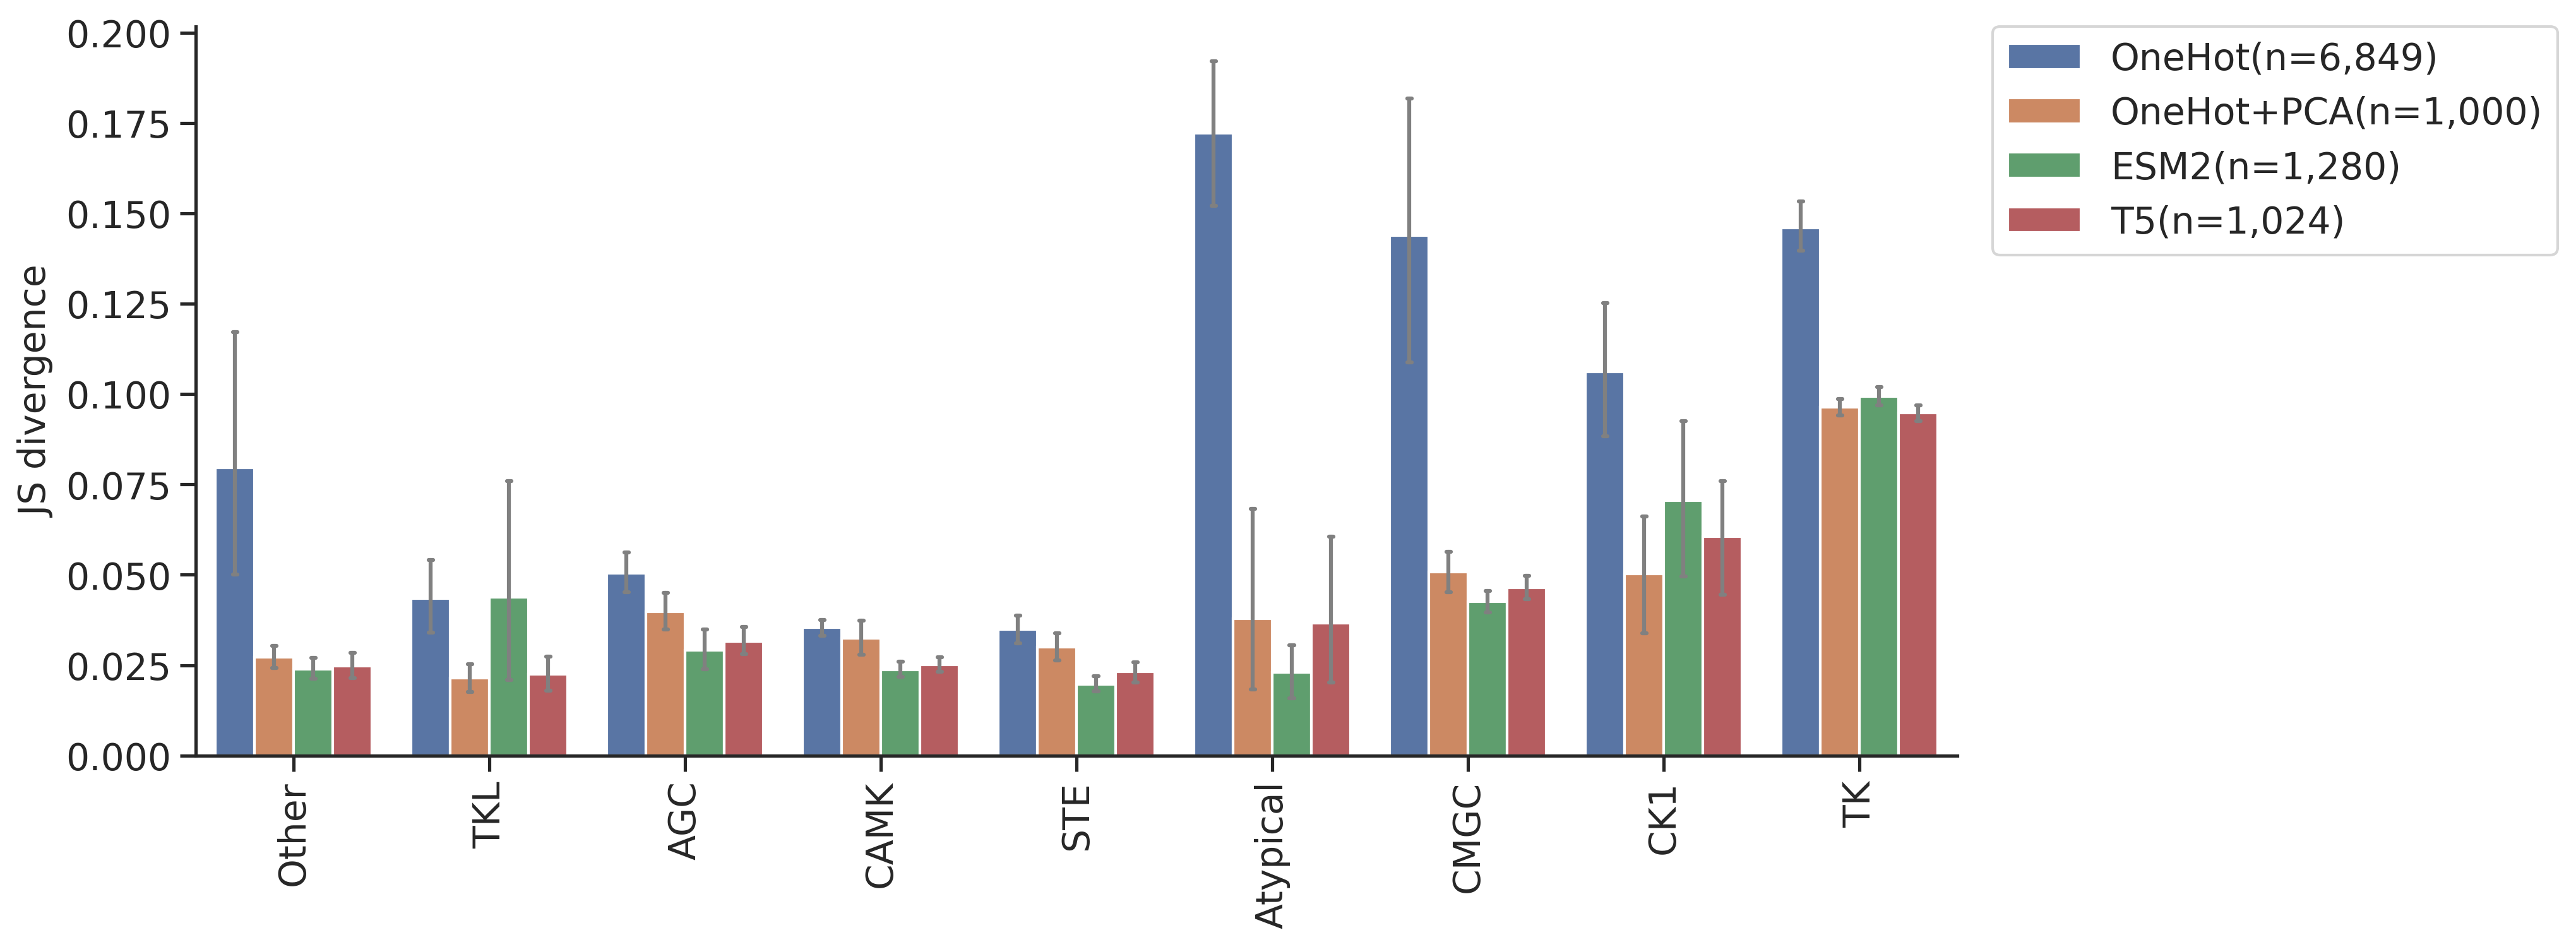

In [18]:
plot_group_bar(pspa_info,cols,group='group')
plt.ylabel('JS divergence')
save_svg('fig/CNN_feature_comparison_group.svg')

### For JS similarity (less differentiated)

In [ ]:
pspa_info['t5'] =jss_df(target,oof_t5)
pspa_info['esm'] =jss_df(target,oof_esm)
pspa_info['onehot'] =jss_df(target,oof_onehot)
pspa_info['onehot_pca'] =jss_df(target,oof_onehot_pca)

In [ ]:
plot_group_bar(pspa_info,['t5','esm','onehot','onehot_pca'],group='group')
plt.ylabel('JS divergence')